In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r^2": r_score,}

In [2]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,7 hours 0 mins
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 13 days
H2O_cluster_name:,H2O_from_python_38066_ia8q9n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.620 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [2]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_02.02_v3.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = []
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=True,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features or "angle" in feature_name:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

# train = h2o.H2OFrame(train_df)
# test = h2o.H2OFrame(test_df)

True
183
['avg_atoms_in_cycle', 'nFaHRing', 'chirality', 'PPSA5', 'tpsa+f', 'RPCS', 'mol_num_cycles', 'GeomShapeIndex', 'angle_R2X2R1', 'nN', 'distance_between_atoms_in_f_group_centers', 'nC', 'nFARing', 'angle_R1X1R2', 'f_freedom', 'naHRing', 'nFAHRing', 'cis/trans', 'dipole_moment', 'f_to_fg', 'f_atom_fraction', 'nFRing', 'nFaRing', 'naRing', 'nFHRing', 'PBF', 'nARing', 'nF', 'dihedral_angle', 'nAHRing', 'nO', 'TASA', 'angle_X2X1R1', 'mol_volume', 'FPSA3', 'PNSA5', 'angle_X1X2R2', 'nHRing', 'pKa', 'logP', 'molecule_type', 'amine_type']
distance_between_atoms_in_f_group_centers [35]
dipole_moment [82]
f_atom_fraction [124]
PBF [40, 71, 127]
mol_volume [127]
FPSA3 [40]
PNSA5 [37, 38]
logP [82, 83]
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182],
      dtype='int64', length=183)
Remains rows:105, amount of features: 42
92 13


In [4]:
X_temp = X.copy()

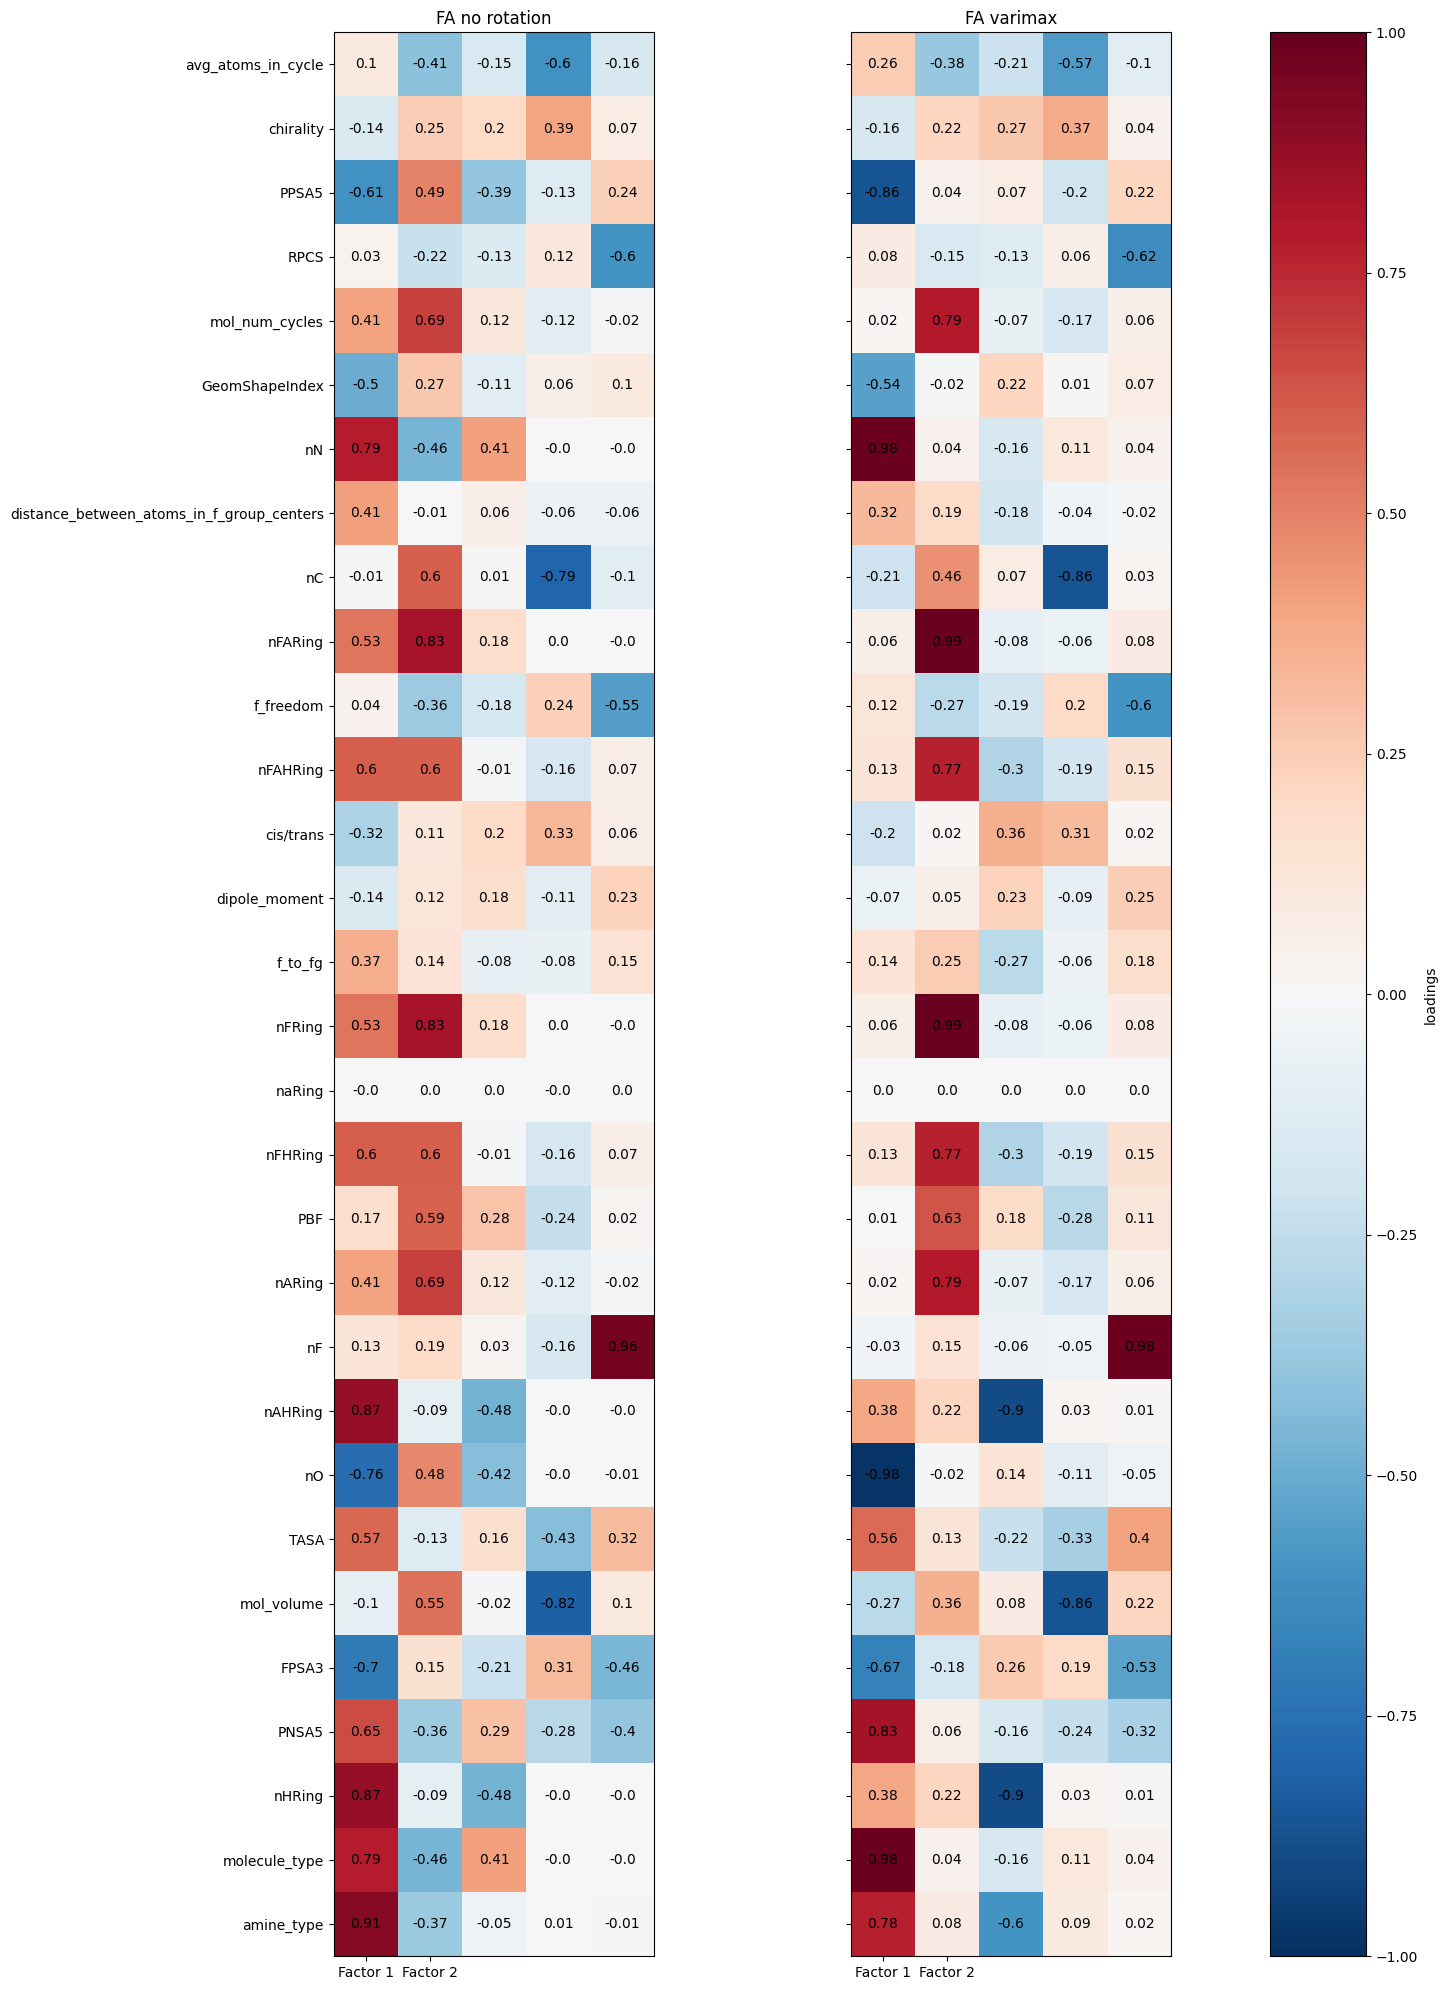

In [5]:
from pandas import read_csv, Series, DataFrame
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 10})
import numpy as np

food = X_temp.copy()

X = StandardScaler().fit_transform(food)  # Standardize the data
factors = 5
#  a list of 2 tuples containing titles for and instances of or class
fas = [
    ("FA no rotation", FactorAnalysis(n_components = factors)),
    ("FA varimax", FactorAnalysis(n_components = factors, rotation="varimax")),
]  

#  Let's prepare some plots on one canvas (subplots)
fig, axes = plt.subplots(ncols=len(fas), figsize=(20, 20))

'''
And loop over the variants of our analysis `fas`, zipped with the 
plot axes `axes`
'''
for ax, (title, fa) in zip(axes, fas):
    #  Fit the model to the standardized food data
    fa = fa.fit(X)
    #  and transpose the component (loading) matrix
    factor_matrix = fa.components_.T
    #  Plot the data as a heat map
    im = ax.imshow(factor_matrix, cmap="RdBu_r", vmax=1, vmin=-1)
    #  and add the corresponding value to the center of each cell
    for (i,j), z in np.ndenumerate(factor_matrix):
        ax.text(j, i, str(z.round(2)), ha="center", va="center")
    #  Tell matplotlib about the metadata of the plot
    ax.set_yticks(np.arange(len(food.columns)))
    if ax.get_subplotspec().is_first_col():
        ax.set_yticklabels(food.columns)
    else:
        ax.set_yticklabels([])
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Factor 1", "Factor 2"])
    #  and squeeze the axes tight, to save space
    plt.tight_layout()
    
#  and add a colorbar
cb = fig.colorbar(im, ax=axes, location='right', label="loadings")
#  show us the plot
plt.show()

<Axes: ylabel='Uniqueness'>

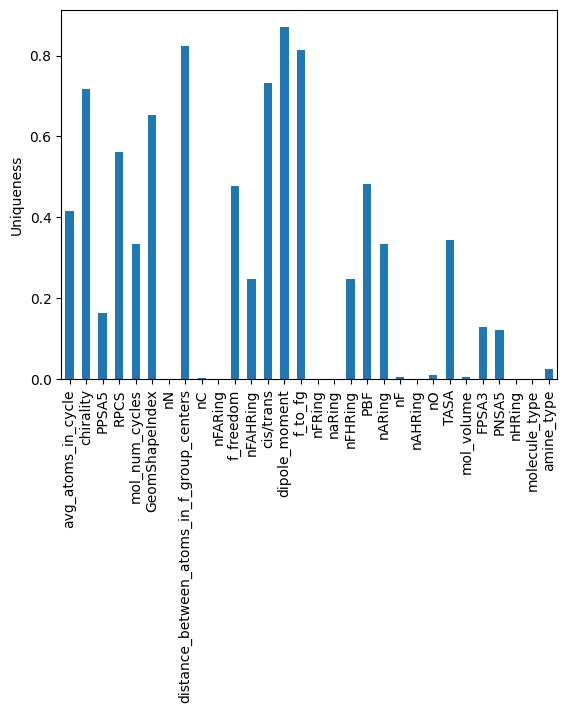

In [6]:
fa = FactorAnalysis(n_components = 5, rotation="varimax")
fa.fit(X)
uniqueness = Series(fa.noise_variance_, index=food.columns)
uniqueness.plot(
    kind="bar",
    ylabel="Uniqueness"
)

<Axes: ylabel='communality'>

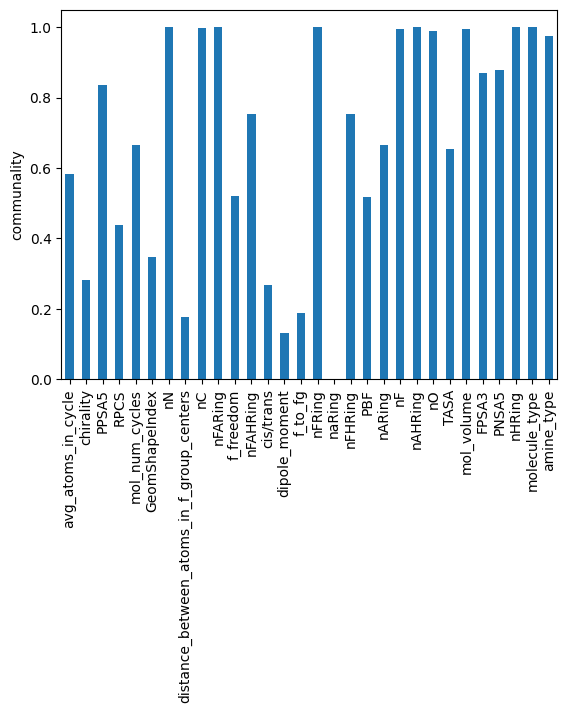

In [7]:
# Communality
communality = Series(np.square(fa.components_.T).sum(axis=1), index=food.columns)
communality.plot(
    kind="bar",
    ylabel="communality"
)

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\38066\AppData\Local\Temp\ipykernel_19772\118360913.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(range(30))


{0: 'avg_atoms_in_cycle', 1: 'chirality', 2: 'PPSA5', 3: 'RPCS', 4: 'mol_num_cycles', 5: 'GeomShapeIndex', 6: 'nN', 7: 'distance_between_atoms_in_f_group_centers', 8: 'nC', 9: 'nFARing', 10: 'f_freedom', 11: 'nFAHRing', 12: 'cis/trans', 13: 'dipole_moment', 14: 'f_to_fg', 15: 'nFRing', 16: 'naRing', 17: 'nFHRing', 18: 'PBF', 19: 'nARing', 20: 'nF', 21: 'nAHRing', 22: 'nO', 23: 'TASA', 24: 'mol_volume', 25: 'FPSA3', 26: 'PNSA5', 27: 'nHRing', 28: 'molecule_type', 29: 'amine_type'}


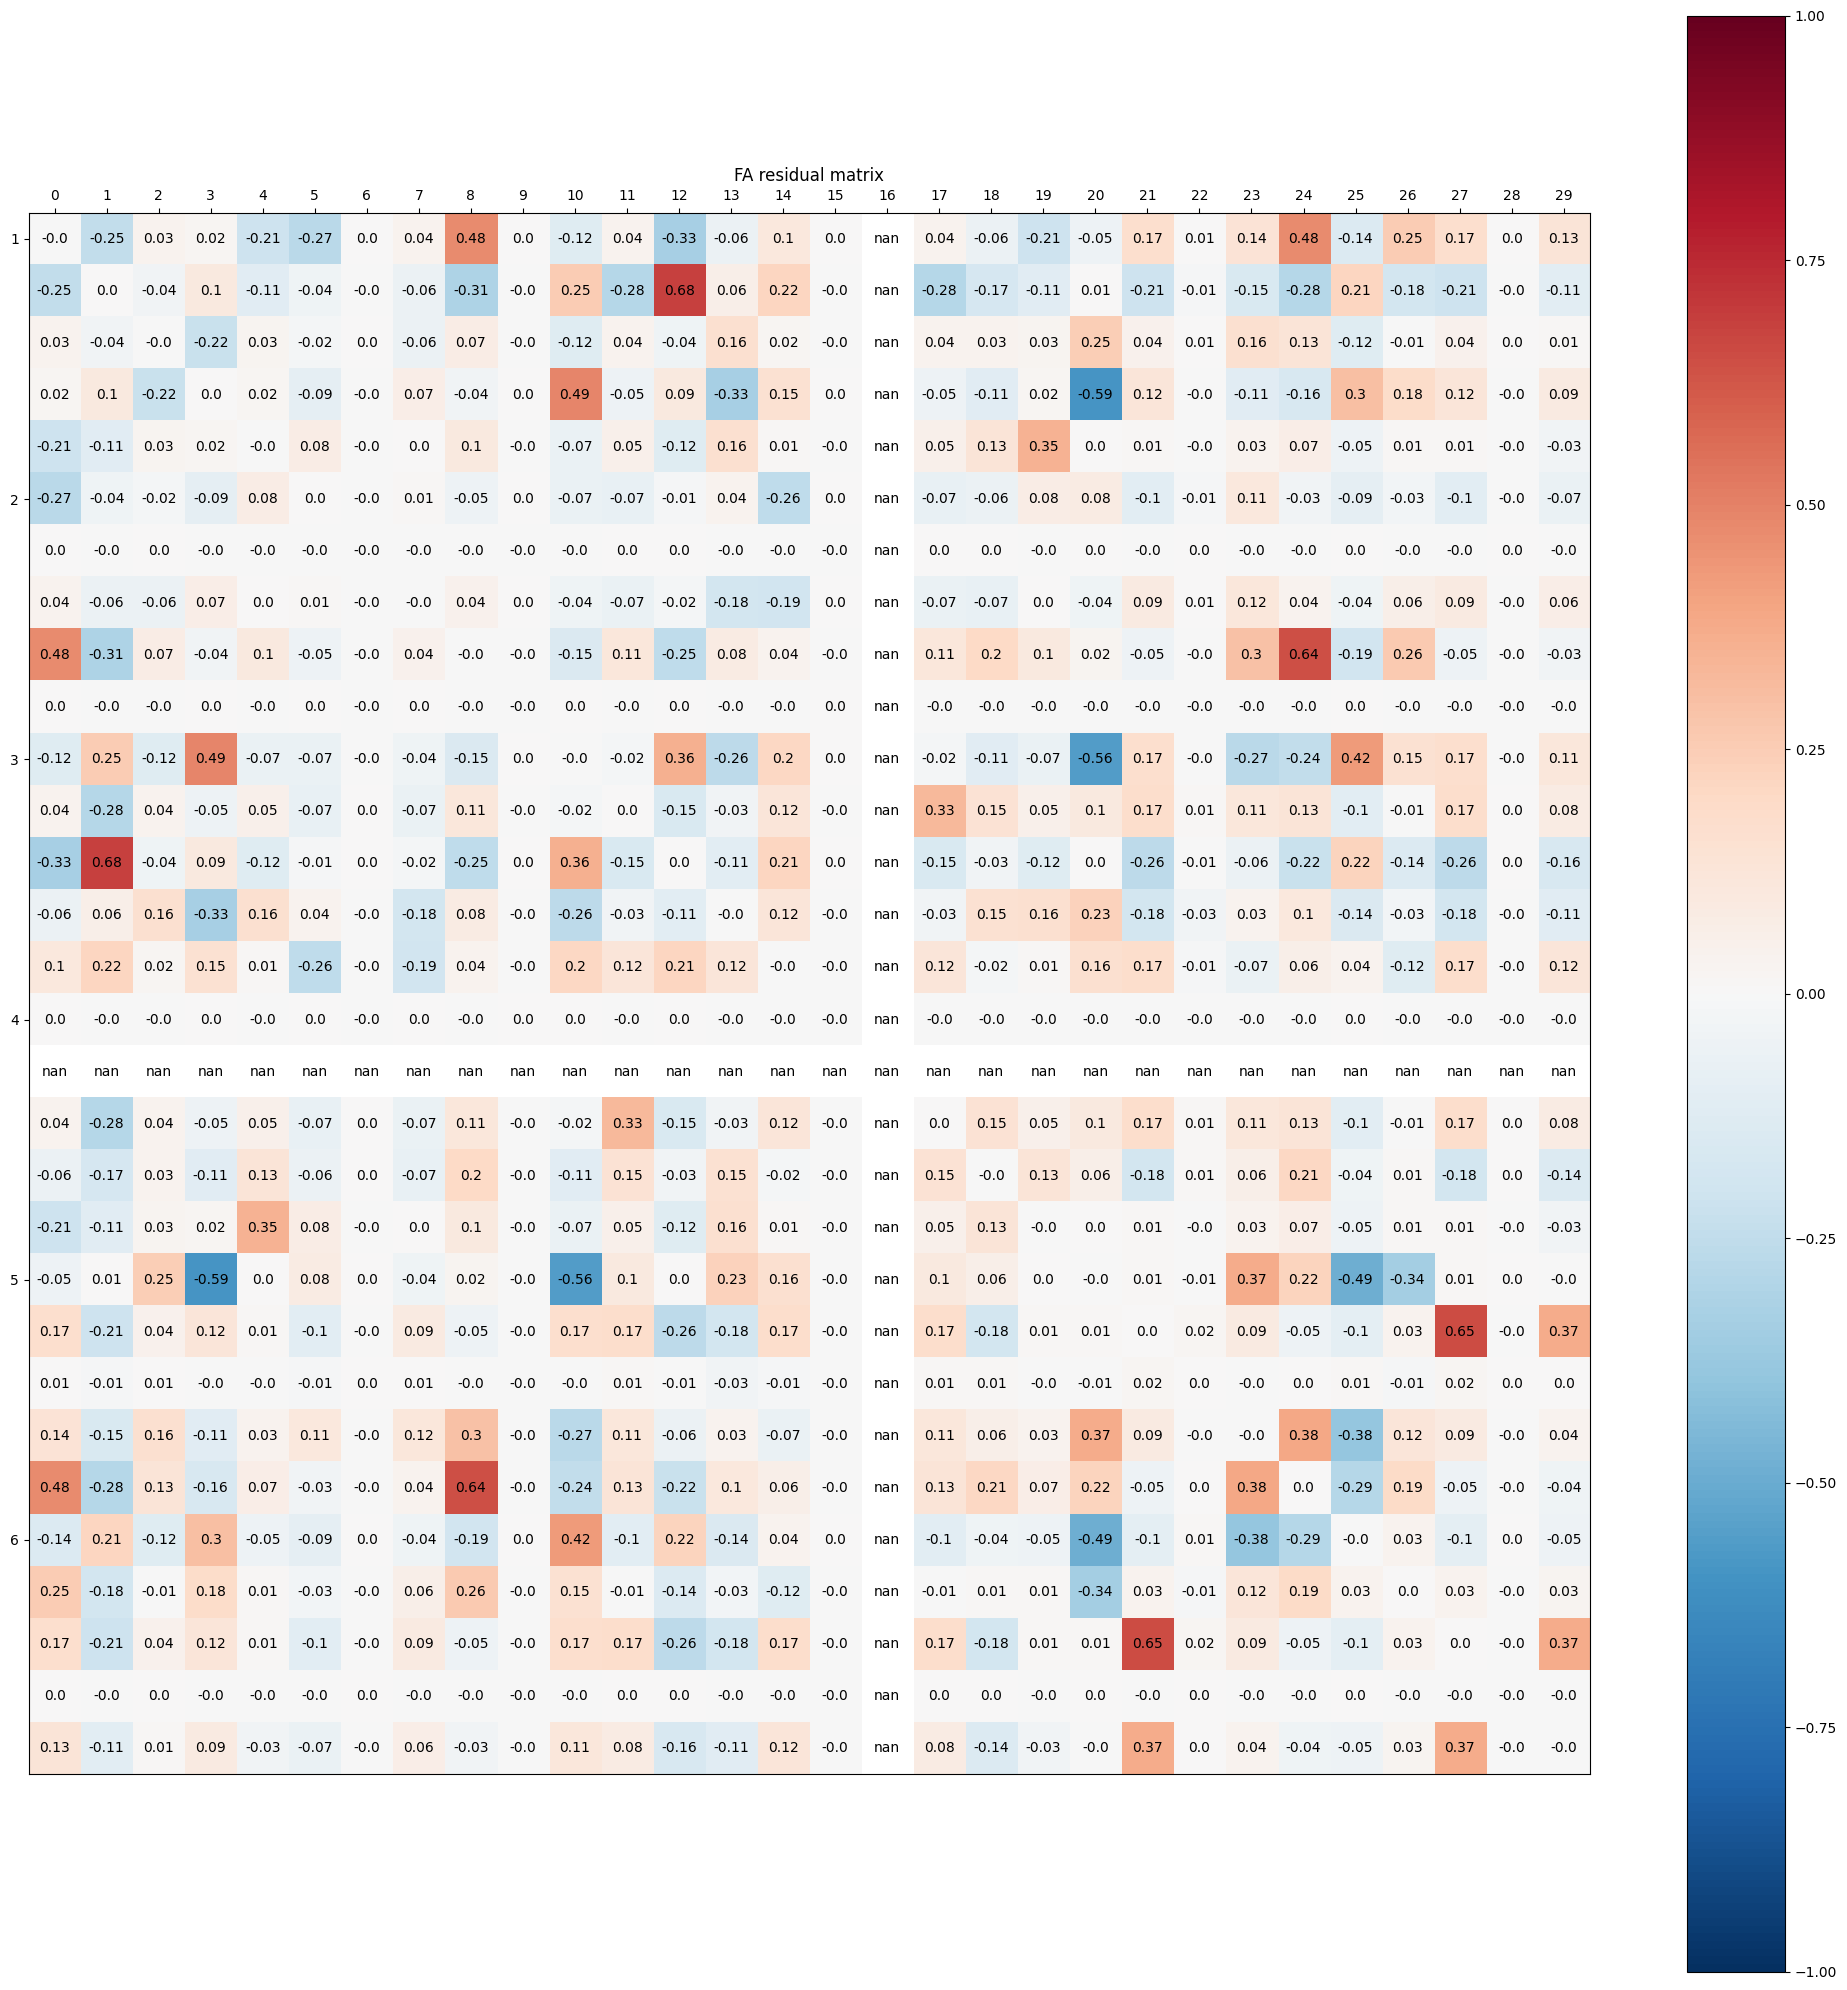

In [28]:
# the word 'lambda' is reserved for a python-operator, so we use the underscore at the end
lambda_ = fa.components_
psi = np.diag(uniqueness)
s = np.corrcoef(np.transpose(X))
sigma = np.matmul(lambda_.T, lambda_) + psi
residuals = (s - sigma)

plt.figure(figsize=(20,20))
ax = plt.axes()
im = ax.imshow(residuals, cmap="RdBu_r", vmin=-1, vmax=1)

feature_name_to_index = {feature_index:food.columns[feature_index] for feature_index in range(len(food.columns))}
print(feature_name_to_index)

ax.tick_params(axis="x", bottom=False, labelbottom=False, top=True, labeltop=True)
ax.tick_params(axis="y", bottom=False, labelbottom=False, left=True, labelleft=True)
ax.set_xticks(range(30))
ax.set_yticklabels(range(30))
for (i,j), z in np.ndenumerate(residuals):
    ax.text(j, i, str(z.round(2)), ha="center", va="center")

fig.colorbar(im, ax=ax, location='right')
ax.set_title("FA residual matrix")
plt.tight_layout()

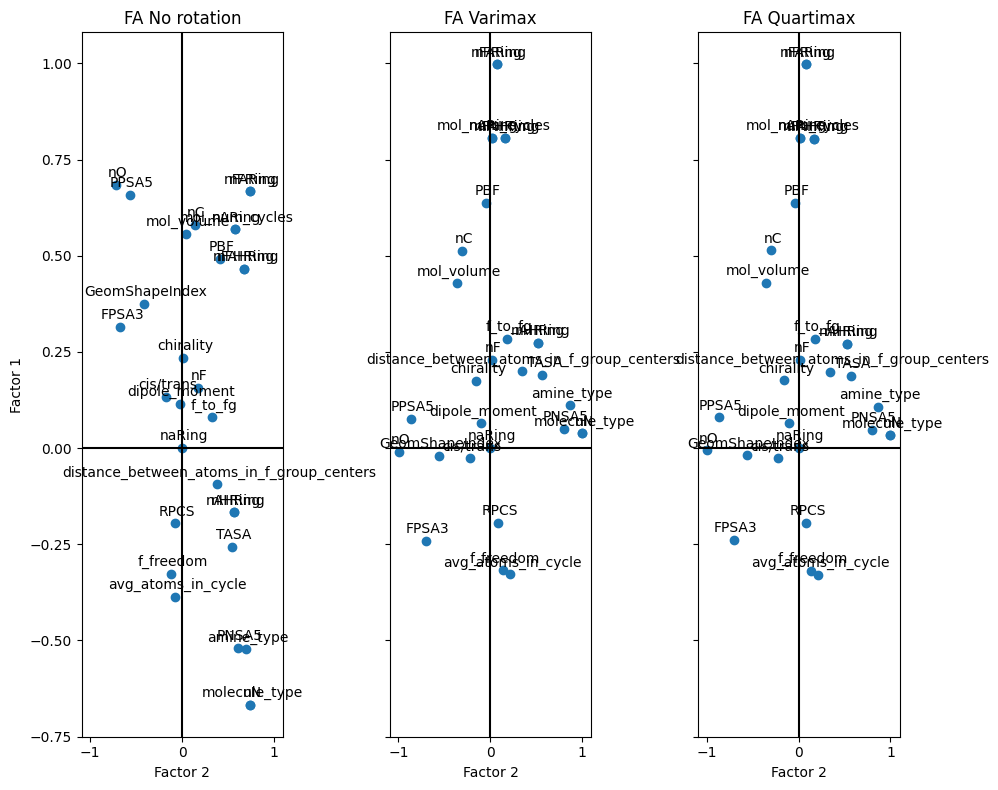

In [29]:
methods = [
    ("FA No rotation", FactorAnalysis(2,)),
    ("FA Varimax", FactorAnalysis(2, rotation="varimax")),
    ("FA Quartimax", FactorAnalysis(2, rotation="quartimax")),
]
fig, axes = plt.subplots(ncols=3, figsize=(10, 8), sharex=True, sharey=True)

for ax, (method, fa) in zip(axes, methods):
    fa = fa.fit(X)

    components = fa.components_

    vmax = np.abs(components).max()
    ax.scatter(components[0,:], components[1, :])
    ax.axhline(0, -1, 1, color='k')
    ax.axvline(0, -1, 1, color='k')
    for i,j, z in zip(components[0, :], components[1, :], food.columns):
        ax.text(i+.02, j+.02, str(z), ha="center")
    ax.set_title(str(method))
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Factor 1")
    ax.set_xlabel("Factor 2")

plt.tight_layout()
plt.show()